# Modeling How to Beat the Streak

In 1941, Joe DiMaggio recorded hits in 56 consecutive games of Major League Baseball. This record has stood for 80 years and is seen as one of the most unlikely to be broken. In 2001, MLB started a fantasy game called Beat the Streak, challenging fans to simply pick, among all player, one who would get a hit on a given day. And then do that for 57 consecutive days to symbolically beat DiMaggio's streak. In 20 years nobody has won but a few have come as close as 51.

In this notebook I aim to take a statistical approach to determining these daily picks in order to give myself the best possible chance I can to win this competition and, with it, the $5.6 million prize.

My first step will be to gather the relevant data and assemble it in a useful way.

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import pybaseball
import statsapi

from datetime import datetime, timedelta
from dateutil import tz
from geopy.geocoders import Nominatim


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


pybaseball.statcast allows me to gather details from of every MLB game since 2017 down to the individual pitch level. As this alone is a lot of data I'll save it as I gather it so I don't have to rerun this part.

In [135]:
# I've set a limit for my data to between the beginning of the 2019 season and June 30th, 2021.. 

data = pybaseball.statcast('2019-03-20', '2019-09-29')

data.to_csv('untouched_2019_statcast_pbp.csv')

data = pybaseball.statcast('2020-07-23', '2020-09-27')

data.to_csv('untouched_2020_statcast_pbp.csv')

data = pybaseball.statcast('2021-04-01', '2021-06-30')

data.to_csv('untouched_2021_statcast_pbp.csv')

This is a large query, it may take a moment to complete


/home/stone11375/anaconda3/lib/python3.8/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 194/194 [01:40<00:00,  1.93it/s]


This is a large query, it may take a moment to complete


100%|██████████| 67/67 [00:35<00:00,  1.87it/s]


This is a large query, it may take a moment to complete


100%|██████████| 91/91 [00:45<00:00,  1.99it/s]


In [197]:
df = pd.concat([pd.read_csv('untouched_2019_statcast_pbp.csv', index_col=0),
                pd.read_csv('untouched_2020_statcast_pbp.csv', index_col=0),
               pd.read_csv('untouched_2021_statcast_pbp.csv', index_col=0)], ignore_index=True)

In [198]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FC,2019-09-29,91.1,-2.16,6.08,"Herrera, Kelvin",641513,516969,strikeout,swinging_strike,NaN,NaN,NaN,NaN,14.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,S,2.0,NaN,2,2,2019,-0.05,0.40,0.08,1.02,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,641470.0,NaN,NaN,5.659540,-132.261173,-7.523466,-1.822484,29.552101,-26.184787,3.34,1.64,NaN,NaN,NaN,89.9,2347.0,5.8,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.71,NaN,NaN,0.0,1.0,0.0,0.0,NaN,66,5,Cutter,5,3,3,5,3,5,3,5,Standard,Standard,187.0,0.011,-0.099
1,FC,2019-09-29,88.2,-2.22,6.07,"Herrera, Kelvin",641513,516969,NaN,foul,NaN,NaN,NaN,NaN,5.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,S,NaN,NaN,2,1,2019,0.19,0.46,0.16,2.29,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,641470.0,NaN,NaN,5.356255,-128.270061,-3.958404,0.855951,27.381318,-26.670237,3.50,1.64,10.0,66.6,-12.0,87.1,2366.0,5.7,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,4,Cutter,5,3,3,5,3,5,3,5,Standard,Standard,158.0,0.000,-0.033
2,FF,2019-09-29,95.8,-1.55,6.41,"Herrera, Kelvin",641513,516969,NaN,ball,NaN,NaN,NaN,NaN,11.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,B,NaN,NaN,1,1,2019,-0.90,1.42,-1.57,2.78,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,641470.0,NaN,NaN,1.949929,-139.338956,-7.096962,-12.028052,30.328764,-12.541891,3.27,1.64,NaN,NaN,NaN,95.2,2235.0,5.9,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,3,4-Seam Fastball,5,3,3,5,3,5,3,5,Standard,Standard,212.0,0.000,0.024
3,FC,2019-09-29,90.1,-2.16,6.01,"Herrera, Kelvin",641513,516969,NaN,ball,NaN,NaN,NaN,NaN,13.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,B,NaN,NaN,0,1,2019,0.14,0.35,-0.06,0.95,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,641470.0,NaN,NaN,4.867683,-130.869340,-7.192694,0.460072,28.163834,-26.922956,3.34,1.64,NaN,NaN,NaN,88.7,2335.0,5.6,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,2,Cutter,5,3,3,5,3,5,3,5,Standard,Standard,159.0,0.000,0.012
4,FF,2019-09-29,98.2,-1.47,6.24,"Herrera, Kelvin",641513,516969,NaN,called_strike,NaN,NaN,NaN,NaN,5.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,S,NaN,NaN,0,0,2019,-0.34,1.17,-0.21,2.78,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,641470.0,NaN,NaN,4.226199,-142.841106,-6.628930,-5.683070,32.358288,-14.785764,3.48,1.64,NaN,NaN,NaN,98.5,2216.0,6.4,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,1,4-Seam Fastball,5,3,3,5,3,5,3,5,Standard,Standard,196.0,0.000,-0.019


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345236 entries, 0 to 1345235
Data columns (total 92 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   pitch_type                       1339446 non-null  object 
 1   game_date                        1345236 non-null  object 
 2   release_speed                    1337915 non-null  float64
 3   release_pos_x                    1337896 non-null  float64
 4   release_pos_z                    1337896 non-null  float64
 5   player_name                      1345236 non-null  object 
 6   batter                           1345236 non-null  int64  
 7   pitcher                          1345236 non-null  int64  
 8   events                           341423 non-null   object 
 9   description                      1345236 non-null  object 
 10  spin_dir                         0 non-null        float64
 11  spin_rate_deprecated             0 non-null       

The various features vary wildly in count. While some of this variation would be expected for columns like "on_3b", "on_2b" and "on_1b," others demonstrate a change in how the data has been collected. For example, despite the presence of an umpire column it doesn't seem like statcast presently collects information about the people umpiring these games.

To start my data cleaning I'll drop columns with only one value.

In [200]:
for col in df.columns:
        if len(df[col].unique()) == 1 and col not in ['home_']:
            df = df.drop([col], axis=1)
print('dropping columns done')

dropping columns done


Now to explore some individual columns to see if they need to be transformed in any way.

In [201]:
df['pitch_type'].value_counts()

FF    474520
SL    241326
SI    155398
CH    150614
CU    117101
FC     89446
FT     59145
KC     29818
FS     20331
FA      1016
CS       355
KN       243
EP        96
FO        36
SC         1
Name: pitch_type, dtype: int64

In [202]:
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'zone', 'des', 'stand', 'p_throws', 'home_team',
       'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes',
       'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b',
       'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'fielder_2', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'babip_value', 'iso_value',
       'launch_speed_angle', 'at_bat_number', 'pitch_number

I'll likely need to transform this into ordinals later.

In [203]:
df['batter'].value_counts()

543760    5434
656555    5384
467793    5272
502671    5209
660670    5205
          ... 
656803       1
641682       1
488984       1
605154       1
664334       1
Name: batter, Length: 1266, dtype: int64

In [204]:
pybaseball.playerid_reverse_lookup([543760, 656803], key_type='mlbam')

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,norwood,james,656803,norwj001,norwoja01,16440,2018.0,2021.0
1,semien,marcus,543760,semim001,semiema01,12533,2013.0,2021.0


In [205]:
df['pitcher'].value_counts()

545333    6639
458681    6246
543037    6141
605400    6057
669456    6045
          ... 
642162       5
545358       5
595943       5
665155       4
608686       3
Name: pitcher, Length: 1144, dtype: int64

In [206]:
df['game_pk'].value_counts()

564909    594
564784    571
565102    547
566939    530
564844    517
         ... 
630851    174
565333    167
633922    164
566187    157
567286    152
Name: game_pk, Length: 4524, dtype: int64

In [207]:
statsapi.schedule(game_id=633588)

[{'game_id': 633588,
  'game_datetime': '2021-06-22T00:10:00Z',
  'game_date': '2021-06-21',
  'game_type': 'R',
  'status': 'Final',
  'away_name': 'Cincinnati Reds',
  'home_name': 'Minnesota Twins',
  'away_id': 113,
  'home_id': 142,
  'doubleheader': 'N',
  'game_num': 1,
  'home_probable_pitcher': 'J.A. Happ',
  'away_probable_pitcher': 'Tyler Mahle',
  'home_pitcher_note': 'Happ owns an 8.68 ERA since the beginning of May, with opposing hitters tallying a 1.035 OPS against the left-hander in that stretch. He has allowed four or more earned runs in six of his past seven starts and last made a quality start on April 28.',
  'away_pitcher_note': 'During a 2-1 win over the Brewers on Wednesday, Mahle tied a career high with 12 strikeouts and got nine of them with his fastball. He is 5-0 with a 2.15 ERA over his past five starts.',
  'away_score': 5,
  'home_score': 7,
  'current_inning': 12,
  'inning_state': 'Bottom',
  'venue_id': 3312,
  'venue_name': 'Target Field',
  'winning_t

These three columns refer to an internal ID system which will have to be consulted.

In [208]:
df['events'].value_counts()

field_out                       132157
strikeout                        79438
single                           47122
walk                             28652
double                           15072
home_run                         11908
force_out                         6751
grounded_into_double_play         6316
hit_by_pitch                      3839
field_error                       2511
sac_fly                           2086
triple                            1346
sac_bunt                          1271
fielders_choice                    773
double_play                        744
fielders_choice_out                538
caught_stealing_2b                 311
strikeout_double_play              256
catcher_interf                     130
other_out                           69
caught_stealing_3b                  21
sac_fly_double_play                 20
pickoff_1b                          15
caught_stealing_home                15
wild_pitch                          12
pickoff_2b               

In [209]:
df['description'].value_counts()

ball                       452760
foul                       235619
hit_into_play              228649
called_strike              222991
swinging_strike            142157
blocked_ball                33225
foul_tip                    12335
swinging_strike_blocked      9954
hit_by_pitch                 3839
foul_bunt                    2947
missed_bunt                   602
pitchout                      105
bunt_foul_tip                  52
foul_pitchout                   1
Name: description, dtype: int64

One thing that's become apparent to me at this point is that many of these features are not necessarily things the user would know prior to the game, such as how hard an individual ball is hit. These features will have to be dropped.

Additionally, some information that the user would know that could be important, such as who the expected starting pitchers are, are not included. At this point we'll use game_pk to add in more information through the MLB-statsapi library.

df.head()

"game_datetime" seems to be in UTC. In order to account for possible differences between day and night games I'll convert it to local time and then to a timestamp..

Now because of the size of the data and the way I'll be manipulating it later, I found it useful to change a number of the object columns into integers and explicitly set types to the smallest possible as early as possible in the process to cut down on run time.

In [210]:
pa_ending_events = np.array(['field_out',
                                'strikeout',
                                'single',
                                'walk',
                                'double',
                                'home_run',
                                'force_out',
                                'grounded_into_double_play',
                                'hit_by_pitch',
                                'field_error',
                                'sac_fly',
                                'triple',
                                'sac_bunt',
                                'fielders_choice',
                                'double_play',
                                'fielders_choice_out',
                                'strikeout_double_play',
                                'catcher_interf',
                                'sac_fly_double_play',
                                'triple_play',
                                'sac_bunt_double_play'])

hit_events = np.array(['single',
                        'double',
                        'home_run',
                        'triple'])
   

In [211]:
def set_types(df):
    
#     First we need to fill in the  missing values in numeric columns to make the type transformation possible
    
    num_columns = ['release_speed', 'batter', 'pitcher', 'zone', 'hit_location', 'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'fielder_2', 'hit_distance_sc', 'release_spin_rate', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'woba_value', 'woba_denom', 'babip_value', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score']

    num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])
    preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_columns)])
    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    t = clf.fit_transform(df)
    
    df[num_columns] = t
    
    
    df['game_date'] = pd.to_datetime(df['game_date'], format='%Y-%m-%d')
    print('datetime done')
    df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else 0)).astype(np.int8)
    print('events done')
    df['batter_righty'] = df['stand'].apply(lambda x: 1 if x == 'R' else 0).astype(np.int8)
    print('stand done')
    df['pitcher_righty'] = df['p_throws'].apply(lambda x: 1 if x == 'R' else 0).astype(np.int8)
    print('pitcher done')
    df['bottom'] = df['inning_topbot'].apply(lambda x: 1 if x == 'Bot' else 0).astype(np.int8)
    print('inning done')
    df['release_speed'] = df['release_speed'].astype(np.int8)
    df['batter'] = df['batter'].astype(np.int32)
    df['pitcher'] = df['pitcher'].astype(np.int32)
    df['zone'] = df['zone'].astype(np.int8)
    df['hit_location'] = df['hit_location'].astype(np.int8)
    df['balls'] = df['balls'].astype(np.uint8)
    df['strikes'] = df['strikes'].astype(np.uint8)
    df['game_year'] = df['game_year'].astype(np.int16)
    df['on_3b'] = df['on_3b'].astype(np.int32)
    df['on_2b'] = df['on_2b'].astype(np.int32)
    df['on_1b'] = df['on_1b'].astype(np.int32)
    df['outs_when_up'] = df['outs_when_up'].astype(np.uint8)
    df['inning'] = df['inning'].astype(np.uint8)
    df['fielder_2'] = df['fielder_2'].astype(np.int32)
    df['hit_distance_sc'] = df['hit_distance_sc'].astype(np.int16)
    df['release_spin_rate'] = df['release_spin_rate'].astype(np.int16)
    df['game_pk'] = df['game_pk'].astype(np.int32)
    df['pitcher.1'] = df['pitcher.1'].astype(np.int32)
    df['fielder_2.1'] = df['fielder_2.1'].astype(np.int32)
    df['fielder_3'] = df['fielder_3'].astype(np.int32)
    df['fielder_4'] = df['fielder_4'].astype(np.int32)
    df['fielder_5'] = df['fielder_5'].astype(np.int32)
    df['fielder_6'] = df['fielder_6'].astype(np.int32)
    df['fielder_7'] = df['fielder_7'].astype(np.int32)
    df['fielder_8'] = df['fielder_8'].astype(np.int32)
    df['fielder_9'] = df['fielder_9'].astype(np.int32)
    df['woba_value'] = df['woba_value'].astype(np.int8)
    df['woba_denom'] = df['woba_denom'].astype(np.int8)
    df['babip_value'] = df['babip_value'].astype(np.int8)
    df['at_bat_number'] = df['at_bat_number'].astype(np.uint8)
    df['pitch_number'] = df['pitch_number'].astype(np.uint8)
    df['home_score'] = df['home_score'].astype(np.uint8)
    df['away_score'] = df['away_score'].astype(np.uint8)
    df['bat_score'] = df['bat_score'].astype(np.uint8)
    df['fld_score'] = df['fld_score'].astype(np.uint8)
    df['post_away_score'] = df['post_away_score'].astype(np.uint8)
    df['post_home_score'] = df['post_home_score'].astype(np.uint8)
    df['post_bat_score'] = df['post_bat_score'].astype(np.uint8)
    df['post_fld_score'] = df['post_fld_score'].astype(np.uint8)
    df = df.select_dtypes(exclude=['object'])
    
    df = df.drop_duplicates()
    
    return(df)

df = set_types(df)

datetime done


<ipython-input-211-c58e6016cd9d>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else 0)).astype(np.int8)


events done
stand done
pitcher done
inning done


Now to drop all rows that don't include a plate appearance ending play

In [212]:
df_filtered = df[df['events'].isin([1,0])]

In [213]:
df_filtered['game_pk'].unique()

array([567343, 567139, 566944, ..., 634622, 634618, 634615], dtype=int32)

At this point, purely for presentational purposes, I'm going to trim the dataframe down to the first 5000 rows. This will allow for the following code to run in a timely manner. The fact of the matter is with a project like this, there's a huge amount of data that could be included, making parts of what's to come run for literal days.

In [214]:
df_filtered = df_filtered.head(5000)

Another factor I'd like to account for is both physical location (whether latitude, longitude, and altitude play a role) as well as weather. To add this in I'll need to map the games to the venue in statsapi.schedule() and then to coordinate data to run through an api called Visual Crossing for weather information. I'll also need to convert the times to local for Visual Crossing.

In [215]:
def convert_UTC_to_local(row):
    venue_coords = pd.read_csv('Parks.csv')
    
    venue_name = row['venue_name']
    game_datetime = row['game_datetime']
    from_zone = tz.gettz('UTC')

    locator = Nominatim(user_agent='myGeocoder')
    try:
        city = venue_coords[venue_coords['NAME'] == row['venue_name']]['CITY'].iloc[0]
        lat = venue_coords[venue_coords['NAME'] == row['venue_name']]['Latitude'].iloc[0]
        lon = venue_coords[venue_coords['NAME'] == row['venue_name']]['Longitude'].iloc[0]
        alt = venue_coords[venue_coords['NAME'] == row['venue_name']]['Altitude'].iloc[0]
    except NameError:
        raise IndexError(venue, index)
    if city == 'Tokyo':
        to_zone = tz.gettz('Asia/Tokyo')
    elif city == 'London':
        to_zone = tz.gettz('Europe/London')
    elif city in ['San Francisco',
                        'Oakland',
                        'Phoenix',
                        'Seattle',
                        'Los Angeles',
                        'San Diego',
                        'Anaheim']:
        to_zone = tz.gettz('America/Los_Angeles')
    elif city == 'Denver':
        to_zone = tz.gettz('America/Denver')
    elif city in ['Minneapolis',
                        'Milwaukee',
                        'Chicago',
                        'St. Louis',
                        'Arlington',
                        'Kansas City',
                        'Houston',
                        'Monterrey',
                        'Omaha',
                        'Dyersville']:
        to_zone = tz.gettz('America/Chicago')
    elif city in ['Buffalo',
                        'Detroit',
                        'Cincinnati',
                        'Pittsburgh',
                        'Tampa Bay',
                        'Philadelphia',
                        'Atlanta',
                        'New York',
                        'Washington',
                        'Cleveland',
                        'Miami',
                        'Boston',
                        'Baltimore',
                        'Toronto',
                        'Williamsport',
                        'Dunedin',
                        'St. Petersburg']:
        to_zone = tz.gettz('America/New_York')
    else:
        raise NameError(venue_name, city)
    utc = datetime.strptime(game_datetime, '%Y-%m-%dT%H:%M:%SZ')
    utc = utc.replace(tzinfo=from_zone)
    local = utc.astimezone(to_zone)

    return(local)

In [216]:
venue_coords = pd.read_csv('Parks.csv')

game_pk_df = pd.DataFrame(columns = statsapi.schedule(game_id=566083)[0].keys())

venue_dict = {}

# for each game, get the available data including probable pitchers
for game in df_filtered['game_pk'].unique():
    game_data = statsapi.schedule(game_id = int(game))[-1]
    game_pk_df = game_pk_df.append(game_data, ignore_index=True)
    print(game)

try:
    for venue in game_pk_df['venue_name'].unique():
        print(venue)
        city = venue_coords[venue_coords['NAME'] == venue]['CITY'].iloc[0]
        lat = venue_coords[venue_coords['NAME'] == venue]['Latitude'].iloc[0]
        lon = venue_coords[venue_coords['NAME'] == venue]['Longitude'].iloc[0]
        alt = venue_coords[venue_coords['NAME'] == venue]['Altitude'].iloc[0]
        venue_dict[venue] = np.array((city, lat, lon, alt))
except IndexError:
#     In case there's a new venue name and Parks.csv needs to be updated
    raise NameError(venue, index)

game_pk_df = game_pk_df.sort_values(['game_datetime'])


# convert UTC time to local time
game_pk_df['local_datetime'] = game_pk_df.apply(lambda row: convert_UTC_to_local(row), axis=1)
game_pk_df['local_datetime'] = game_pk_df['local_datetime'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S"))

# create a dictionary to map each start time with the associated venues to cut down on api calls
datetime_coordinate_matching = {}
for index, row in game_pk_df.iterrows():
    city, lat, lon, alt = venue_dict[row['venue_name']]
    dc_datetime = row['local_datetime']
    if dc_datetime in datetime_coordinate_matching.keys():
        datetime_coordinate_matching[dc_datetime].append(','.join([str(lat), str(lon)]))
    else:
        datetime_coordinate_matching[dc_datetime] = [','.join([str(lat), str(lon)])]

game_pk_df['coordinates'] = game_pk_df['venue_name'].apply(lambda x: ','.join(venue_dict[x][1:3]))
game_pk_df['alt'] = game_pk_df['venue_name'].apply(lambda x: venue_dict[x][3])

567343
567139
566944
566848
566647
566551
566452
566260
566070
565975
565782
565493
565107
564913
564814
567342
567341
567138
Guaranteed Rate Field
Citizens Bank Park
Rogers Centre
Globe Life Park in Arlington
Busch Stadium
Oracle Park
T-Mobile Park
PNC Park
Citi Field
Nationals Park
Kauffman Stadium
Coors Field
Fenway Park
Chase Field
Angel Stadium


In [217]:
game_pk_df.head()

,game_id,game_datetime,game_date,game_type,status,away_name,home_name,away_id,home_id,doubleheader,game_num,home_probable_pitcher,away_probable_pitcher,home_pitcher_note,away_pitcher_note,away_score,home_score,current_inning,inning_state,venue_id,venue_name,winning_team,losing_team,winning_pitcher,losing_pitcher,save_pitcher,summary,local_datetime,coordinates,alt
16,567341,2019-09-28T03:33:00Z,2019-09-28,R,Final,Detroit Tigers,Chicago White Sox,116,145,Y,2,Ivan Nova,Tyler Alexander,Nova is 2-0 with a 3.72 ERA in three starts ag...,Alexander will look for his second win at the ...,4,3,9,Bottom,4,Guaranteed Rate Field,Detroit Tigers,Chicago White Sox,Buck Farmer,Alex Colome,Joe Jimenez,2019-09-28 - Detroit Tigers (4) @ Chicago Whit...,2019-09-27T22:33:00,"41.829892,-87.633703",594
15,567342,2019-09-28T19:40:00Z,2019-09-28,R,Final,Detroit Tigers,Chicago White Sox,116,145,Y,1,Reynaldo Lopez,Matthew Boyd,"López, who owns a 10.29 ERA in his last three ...","After a rough summer stretch, Boyd has a chanc...",1,7,9,Top,4,Guaranteed Rate Field,Chicago White Sox,Detroit Tigers,Reynaldo Lopez,Matthew Boyd,None,2019-09-28 - Detroit Tigers (1) @ Chicago Whit...,2019-09-28T14:40:00,"41.829892,-87.633703",594
17,567138,2019-09-28T22:05:00Z,2019-09-28,R,Final,Miami Marlins,Philadelphia Phillies,146,143,N,1,Zach Eflin,Caleb Smith,Eflin has been a better version of himself sin...,Smith enters his final start with 167 strikeou...,3,9,9,Top,2681,Citizens Bank Park,Philadelphia Phillies,Miami Marlins,Zach Eflin,Caleb Smith,None,2019-09-28 - Miami Marlins (3) @ Philadelphia ...,2019-09-28T18:05:00,"39.906109,-75.166485",19
1,567139,2019-09-29T19:05:00Z,2019-09-29,R,Final,Miami Marlins,Philadelphia Phillies,146,143,N,1,Blake Parker,Sandy Alcantara,The Phillies are starting Parker for the secon...,Alcantara's goals are high for Closing Day. He...,4,3,9,Bottom,2681,Citizens Bank Park,Miami Marlins,Philadelphia Phillies,Sandy Alcantara,Blake Parker,Tyler Kinley,2019-09-29 - Miami Marlins (4) @ Philadelphia ...,2019-09-29T15:05:00,"39.906109,-75.166485",19
3,566848,2019-09-29T19:05:00Z,2019-09-29,R,Final,New York Yankees,Texas Rangers,147,140,N,1,Lance Lynn,Chad Green,Lynn snapped a five-loss slide by beating the ...,Masahiro Tanaka had been announced as the prob...,1,6,9,Top,13,Globe Life Park in Arlington,Texas Rangers,New York Yankees,Lance Lynn,Masahiro Tanaka,None,2019-09-29 - New York Yankees (1) @ Texas Rang...,2019-09-29T14:05:00,"32.751164,-97.082546",549


In [218]:
from api_keys import visual_crossing
import requests

api_counter = 0

weather_df = pd.DataFrame()
for key, value in datetime_coordinate_matching.items():
    print(key)
    url_locations = '|'.join(value)
    URL = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?&aggregateHours=1&startDateTime={key}&endDateTime={key}&unitGroup=us&contentType=json&location={url_locations}&key={visual_crossing}'
    global api_counter
#     api is limited to 1000 free calls per day, after which it's $0.0001 per result
    if api_counter == 1000:
        print('Prepreprocessing will continue at ' + (datetime.now()+timedelta(seconds = 86400)).strftime('%H:%M:%S'))
        sleep(86400)
        api_counter = 0
    try:
        api_counter += 1
        response = requests.get(URL)
        data = response.json()
        locations = list(data['locations'].keys())
        for each in locations:
            values = data['locations'][each]['values'][0]
            weather_df = weather_df.append({**{'coordinates': each}, **values}, ignore_index=True)
    except:
        raise IndexError(key, value, response)

weather_df['datetimeStr'] = weather_df['datetimeStr'].apply(lambda x: x[:-6])
weather_df = weather_df.rename(columns={'datetimeStr': 'local_datetime'})

# merge all this new data together

games_and_weather = pd.merge(
    game_pk_df,
    weather_df,
    how="left",
    on=None,
    left_on=['local_datetime', 'coordinates'],
    right_on=['local_datetime', 'coordinates'],
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_gpk", "_acw"),
    copy=True,
    indicator=False,
    validate=None,
)

df_detailed = pd.merge(
    games_and_weather,
    df_filtered,
    how="right",
    on=None,
    left_on='game_id',
    right_on='game_pk',
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_gaw", "_dff"),
    copy=True,
    indicator=False,
    validate=None,
)

2019-09-27T22:33:00
2019-09-28T14:40:00
2019-09-28T18:05:00
2019-09-29T15:05:00
2019-09-29T14:05:00
2019-09-29T12:05:00
2019-09-29T15:07:00
2019-09-29T12:07:00
2019-09-29T12:10:00
2019-09-29T14:10:00
2019-09-29T13:10:00
2019-09-29T15:10:00
2019-09-29T14:15:00


There's a couple more pieces of information I'd like to add in, namely whether a game was planned to be only 7 innings long, as is true in doubleheaders in 2020 and 2021 (due to COVID), and whether a designated hitter is used, which could indicate longer outings for the starting pitcher.

In [219]:
american_league_teams = np.array(['Boston Red Sox', 'Houston Astros', 'Chicago White Sox', 'Tampa Bay Rays', 'Oakland Athletics', 'Seattle Mariners', 'New York Yankees', 'Toronto Blue Jays', 'Los Angeles Angels', 'Cleveland Indians', 'Detroit Tigers', 'Kansas City Royals', 'Minnesota Twins', 'Texas Rangers', 'Baltimore Orioles'])

In [220]:
df_detailed['covid_doubleheader'] = df_detailed.apply(lambda row: 1 if row['game_year'] in [2020, 2021] and row['doubleheader'] =='Y' else 0, axis=1)



df_detailed['designated_hitter'] = df_detailed.apply(lambda row: 1 if row['home_name'] in american_league_teams or row['game_year'] == 2020 else 0, axis = 1)

And we'll save our dataframe here in case something were to go wrong.

In [221]:
df_detailed.to_csv('df_detailed')

At this point I have a good amount of data but I'm skeptical any model I use would be able to understand who is a good hitter or pitcher, two factors that would likely be extremely relevant. To make up for this I'm going to assemble a handful of statistics for each player based on their performance in recent history - the previous 2 years.

In [222]:
# data = statcast('2017-01-01', '2017-12-31')

# data.to_csv('untouched_2017_statcast_pbp.csv')



# data = statcast('2018-01-01', '2018-12-31')

# data.to_csv('untouched_2018_statcast_pbp.csv')

history = pd.concat([
                    set_types(pd.read_csv('untouched_2017_statcast_pbp.csv')),
                   set_types(pd.read_csv('untouched_2018_statcast_pbp.csv')),
                   set_types(pd.read_csv('untouched_2019_statcast_pbp.csv')),
                   set_types(pd.read_csv('untouched_2020_statcast_pbp.csv')),
                   set_types(pd.read_csv('untouched_2021_statcast_pbp.csv'))
                    ], ignore_index=True)

datetime done


<ipython-input-211-c58e6016cd9d>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else 0)).astype(np.int8)


events done
stand done
pitcher done
inning done
datetime done


<ipython-input-211-c58e6016cd9d>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else 0)).astype(np.int8)


events done
stand done
pitcher done
inning done
datetime done


<ipython-input-211-c58e6016cd9d>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else 0)).astype(np.int8)


events done
stand done
pitcher done
inning done
datetime done


<ipython-input-211-c58e6016cd9d>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else 0)).astype(np.int8)


events done
stand done
pitcher done
inning done
datetime done


<ipython-input-211-c58e6016cd9d>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['events'] = df['events'].apply(lambda x: 1 if x in hit_events else (0 if x in pa_ending_events else 0)).astype(np.int8)


events done
stand done
pitcher done
inning done


In [223]:
def derived_cumulative_stats(player, stats_type, history, start_date=None, end_date=datetime.strptime('2021-06-30', '%Y-%m-%d')):
    print(end_date)
    print(player)

#     in order to speed this up and cut down on api calls, I'll simply be slicing a collection of all statcast data since 2017 (2 years prior to the earliest data I'm modeling)

    if start_date == None:
        start_date = end_date-timedelta(weeks=104)
    if type(player) == str:
#         playerid_lookup has trouble accounting for 3 names
        if player[-3:] == 'Jr.':
            player = player[:-4]
        player = player.split(' ')
        player.reverse()
        try:
            player_info = pybaseball.playerid_lookup(player[0], player[-1])
            if len(player_info) >1:
                player_info = player_info.iloc[0]
                player = player_info['key_mlbam']
            elif player_info.empty:
                player_info = pybaseball.playerid_lookup(player[0], player[-1], fuzzy=True).iloc[0]
                player = player_info['key_mlbam']
            else:
                try:
                    player = player_info.iloc[0]['key_mlbam']
                except:
                    raise NameError(player_info, player)
        except:
            raise NameError(player)
            
    history = history[(history['game_date'] >= start_date) & (history['game_date'] <= end_date)]
    print('game_date filtered')
    if stats_type == 'pitcher':
        try:
            history = history[history['pitcher'] == player]
        except:
            raise NameError(player)
        print('player filtered')
    #   PITCH METRICS
        pitches = {}
        while True:
            try:
                pitches['pitch_hand'] = statsapi.player_stat_data(player)['pitch_hand']
                break
            except:
                print('pitch_hand_error')
                sleep(10)
        print('pitch_hand')
    #     filter history down to PA-enders
        history = history[history['events'].isin([1, 0])]
        print('pa ending events')
    #    PLAYER METRICS
        games = history['game_pk'].unique()
        at_bat_list = []
        num_hits_list = []
        for game in games:
            game = history[history['game_pk'] == game]
            inning = game['inning'].max()
            at_bats = len(game)
            at_bat_list.append(at_bats)
            for i in range(1, inning+1):
                num_hits = len(game[(game['inning'] == i) & (game['events'] == 1)])
                num_hits_list.append(num_hits)
        pitches['games_played_last_2_years_pitcher'] = len(games)
        pitches['avg_PAs_per_apparence_pitcher'] = np.array(at_bat_list).mean()
        pitches['avg_hits_per_inning'] = np.array(num_hits_list).mean()

#         L/R splits
        left_pitcher = history[history['batter_righty'] == 0]
        right_pitcher = history[history['batter_righty'] == 1]
        l_pas = len(left_pitcher)
        r_pas = len(right_pitcher)
        l_hits = len(left_pitcher[(history['events'] == 1)])
        r_hits = len(right_pitcher[(history['events'] == 1)])

        if l_pas > 0 and r_pas > 0:
            pitches['H/PA_pitcher'] = (l_hits + r_hits)/(l_pas + r_pas)
            pitches['against_lefties_H/PA'] = (l_hits)/(l_pas)
            pitches['against_righties_H/PA'] = (r_hits)/(r_pas)
        elif l_pas > 0:
            pitches['H/PA_pitcher'] = (l_hits + r_hits)/(l_pas + r_pas)
            pitches['against_lefties_H/PA'] = (l_hits)/(l_pas)
            pitches['against_righties_H/PA'] = 0
        elif r_pas > 0:
            pitches['H/PA_pitcher'] = (l_hits + r_hits)/(l_pas + r_pas)
            pitches['against_lefties_H/PA'] = 0
            pitches['against_righties_H/PA'] = (r_hits)/(r_pas)
        else:
            pitches['H/PA_pitcher'] = 0
            pitches['against_lefties_H/PA'] = 0
            pitches['against_righties_H/PA'] = 0
        return(pitches)

    
    elif stats_type == 'batter':
        history = history[history['batter'] == player]


#     filter history down to PA-enders
        history = history[history['events'].isin([1, 0])]

#     H/PA per pitch type
#     K/PA per pitch type
#     H/PA vs righties, lefties
#     PA/G
#     avg_launch_angle
#     avg_launch_speed
#     xBA based on estimated_ba_using_speedangle



        # pitches = history['pitch_type'].unique()
        games = history['game_pk'].unique()
        pas_list = []

        batter = {}

        for game in games:
            pas = len(history[history['game_pk'] == game])
            # print(pas)
            pas_list.append(pas)
        batter['games_played_last_2_years_batter'] = len(games)
        batter['PA/G_batter'] = np.array(pas_list).mean()

#         righty/lefty split
        pitcher_right = history[history['pitcher_righty'] == 1]
        pas_r = len(pitcher_right)
        hits_r = len(pitcher_right[pitcher_right['events'] == 1])

        if pas_r > 0:
            batter['H/PA_against_R'] = hits_r/pas_r
        else:
            batter['H/PA_against_R'] = 0

        pitcher_left = history[history['pitcher_righty'] == 0]
        pas_l = len(pitcher_left)
        hits_l = len(pitcher_left[pitcher_left['events'] == 1])

        if pas_l > 0:
            batter['H/PA_against_L'] = hits_l/pas_l
        else:
            batter['H/PA_against_L'] = 0

        if pas_r > 0 or pas_l > 0:
            batter['H/PA_batter'] = (hits_r+hits_l)/(pas_r+pas_l)
        else:
            batter['H/PA_batter'] = 0
        batter['avg_launch_angle'] = history['launch_angle'].mean()
        batter['avg_launch_speed'] = history['launch_speed'].mean()
        batter['xBA'] = history['estimated_ba_using_speedangle'].mean()

        return(batter)

We'll run each projected starting pitcher through the function, derived_cumulative_stats, to assemble their time adjusted statistics.

In [224]:
pitcher_df = pd.concat([df_detailed[['game_id', 'game_date_gaw', 'away_probable_pitcher']].rename(columns={'away_probable_pitcher': 'probable_pitcher'}), df_detailed[['game_id', 'game_date_gaw', 'home_probable_pitcher']].rename(columns={'home_probable_pitcher': 'probable_pitcher'})])
pitcher_df = pitcher_df.drop_duplicates()
pitcher_df['probable_pitcher'] = pitcher_df['probable_pitcher'].replace('', np.nan)
pitcher_df = pitcher_df.dropna(subset=['probable_pitcher'])
pitcher_df = pitcher_df.reset_index(drop=True)

pitcher_stats = pitcher_df.apply(lambda row: pd.Series(derived_cumulative_stats(row['probable_pitcher'], 'pitcher', history, end_date=datetime.strptime(row['game_date_gaw'], '%Y-%m-%d')-timedelta(days=1))), axis = 1)

pitcher_df = pd.merge(
    pitcher_stats,
    pitcher_df,
    how="left",
    on=None,
    left_on=None,
    right_on=None,
    left_index=True,
    right_index=True,
    sort=False,
    suffixes=("_s", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)

2019-09-28 00:00:00
Spencer Turnbull
game_date filtered
player filtered
pitch_hand
pa ending events
2019-09-28 00:00:00
Sandy Alcantara


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Blake Snell
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Chad Green
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Derek Holland
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Rich Hill
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Tanner Roark
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Tyler Mahle
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Mike Soroka
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Mike Clevinger
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Martin Perez
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Adrian Houser
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Chandler Shepherd
game_date filtered
player filtered
pitch_hand
pa ending events
2019-09-28 00:00:00
Michel Baez
No identically matched names found! Returning the 5 most similar names.


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Gerrit Cole
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-27 00:00:00
Matthew Boyd
No identically matched names found! Returning the 5 most similar names.
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-27 00:00:00
Tyler Alexander
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-27 00:00:00
Caleb Smith
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Ross Detwiler
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Blake Parker
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Clay Buchholz
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Lance Lynn
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Jack Flaherty
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Dereck Rodriguez
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Justin Dunn
game_date filtered
player filtered
pitch_hand
pa ending events
2019-09-28 00:00:00
Trevor Williams


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Noah Syndergaard
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Joe Ross
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Jorge Lopez
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Jeff Hoffman
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Eduardo Rodriguez
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-28 00:00:00
Taijuan Walker
game_date filtered
player filtered
pitch_hand
pa ending events
2019-09-28 00:00:00
Dillon Peters


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-27 00:00:00
Reynaldo Lopez
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-27 00:00:00
Ivan Nova
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


2019-09-27 00:00:00
Zach Eflin
game_date filtered
player filtered
pitch_hand
pa ending events


<ipython-input-223-0ce478da99d7>:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  l_hits = len(left_pitcher[(history['events'] == 1)])
<ipython-input-223-0ce478da99d7>:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hits = len(right_pitcher[(history['events'] == 1)])


In order to properly pair batters with their pitcher we'll need to split home and away batters and re-merge those dataframes by matching them with their proper pitcher.

In [225]:
home_batters = df_detailed[df_detailed['bottom'] == 1]
away_batters = df_detailed[df_detailed['bottom'] == 0]

df_wpitching_p1 = pd.merge(
    pitcher_df,
    home_batters,
    how="right",
    on=None,
    left_on=['game_id', 'probable_pitcher'],
    right_on=['game_id', 'away_probable_pitcher'],
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_p", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)

df_wpitching_p2 = pd.merge(
    pitcher_df,
    away_batters,
    how="right",
    on=None,
    left_on=['game_id', 'probable_pitcher'],
    right_on=['game_id', 'home_probable_pitcher'],
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_p", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)
df_wpitching = pd.concat([df_wpitching_p1, df_wpitching_p2], ignore_index=True)
df_wpitching = df_wpitching.sort_values(['game_date_gaw_df', 'game_pk','home_name', 'inning', 'bottom', 'outs_when_up', 'at_bat_number', 'pitch_number']).reset_index(drop=True)

#         Makes explicit the target value and drops repeat occurences of the target value in each game played

df_wpitching['got_a_hit'] = df_wpitching.apply(lambda row: 1 if row['events'] == 1 else 0, axis=1)
df_wpitching = df_wpitching.sort_values('got_a_hit').drop_duplicates(subset=['game_id', 'batter'], keep='last').sort_values(['game_date_gaw_df', 'game_pk','home_name', 'inning', 'bottom', 'outs_when_up', 'at_bat_number', 'pitch_number']).reset_index(drop=True)
        

At this point it's safe to run our batters through the batter half of the derived_cumulative_stats function.

In [226]:
df_wpitching.columns.to_list()

['pitch_hand',
 'games_played_last_2_years_pitcher',
 'avg_PAs_per_apparence_pitcher',
 'avg_hits_per_inning',
 'H/PA_pitcher',
 'against_lefties_H/PA',
 'against_righties_H/PA',
 'game_id',
 'game_date_gaw_p',
 'probable_pitcher',
 'game_datetime',
 'game_date_gaw_df',
 'game_type',
 'status',
 'away_name',
 'home_name',
 'away_id',
 'home_id',
 'doubleheader',
 'game_num',
 'home_probable_pitcher',
 'away_probable_pitcher',
 'home_pitcher_note',
 'away_pitcher_note',
 'away_score_gaw',
 'home_score_gaw',
 'current_inning',
 'inning_state',
 'venue_id',
 'venue_name',
 'winning_team',
 'losing_team',
 'winning_pitcher',
 'losing_pitcher',
 'save_pitcher',
 'summary',
 'local_datetime',
 'coordinates',
 'alt',
 'wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'heatindex',
 'cloudcover',
 'mint',
 'datetime',
 'precip',
 'solarradiation',
 'weathertype',
 'snowdepth',
 'sealevelpressure',
 'snow',
 'dew',
 'humidity',
 'precipcover',
 'wgust',
 'conditions',
 'windchil

In [227]:
batting_stats = df_wpitching.apply(lambda row: pd.Series(derived_cumulative_stats(row['batter'], 'batter', history, end_date=datetime.strptime(row['game_date_gaw_df'], '%Y-%m-%d')-timedelta(days=1))), axis = 1)


df_final = pd.merge(
    batting_stats,
    df_wpitching,
    how="right",
    on=None,
    left_on=None,
    right_on=None,
    left_index=True,
    right_index=True,
    sort=False,
    suffixes=("_bs", "_df"),
    copy=True,
    indicator=False,
    validate=None,
)

2019-09-27 00:00:00
621573
game_date filtered
2019-09-27 00:00:00
446481
game_date filtered
2019-09-27 00:00:00
596748
game_date filtered
2019-09-27 00:00:00
656514
game_date filtered
2019-09-27 00:00:00
620453
game_date filtered
2019-09-27 00:00:00
434158
game_date filtered
2019-09-27 00:00:00
542932
game_date filtered
2019-09-27 00:00:00
500743
game_date filtered
2019-09-27 00:00:00
435522
game_date filtered
2019-09-27 00:00:00
516770
game_date filtered
2019-09-27 00:00:00
595751
game_date filtered
2019-09-27 00:00:00
601713
game_date filtered
2019-09-27 00:00:00
514917
game_date filtered
2019-09-27 00:00:00
594838
game_date filtered
2019-09-27 00:00:00
547180
game_date filtered
2019-09-27 00:00:00
656371
game_date filtered
2019-09-27 00:00:00
623912
game_date filtered
2019-09-27 00:00:00
445988
game_date filtered
2019-09-27 00:00:00
544725
game_date filtered
2019-09-27 00:00:00
641313
game_date filtered
2019-09-27 00:00:00
621514
game_date filtered
2019-09-27 00:00:00
500135
game_da

game_date filtered
2019-09-28 00:00:00
644374
game_date filtered
2019-09-28 00:00:00
641343
game_date filtered
2019-09-28 00:00:00
605182
game_date filtered
2019-09-28 00:00:00
645302
game_date filtered
2019-09-28 00:00:00
596019
game_date filtered
2019-09-28 00:00:00
605548
game_date filtered
2019-09-28 00:00:00
467793
game_date filtered
2019-09-28 00:00:00
614177
game_date filtered
2019-09-28 00:00:00
605452
game_date filtered
2019-09-28 00:00:00
594809
game_date filtered
2019-09-28 00:00:00
435559
game_date filtered
2019-09-28 00:00:00
502273
game_date filtered
2019-09-28 00:00:00
594694
game_date filtered
2019-09-28 00:00:00
506703
game_date filtered
2019-09-28 00:00:00
608700
game_date filtered
2019-09-28 00:00:00
606992
game_date filtered
2019-09-28 00:00:00
656185
game_date filtered
2019-09-28 00:00:00
664057
game_date filtered
2019-09-28 00:00:00
600466
game_date filtered
2019-09-28 00:00:00
572191
game_date filtered
2019-09-28 00:00:00
475582
game_date filtered
2019-09-28 00:0

game_date filtered
2019-09-28 00:00:00
595281
game_date filtered
2019-09-28 00:00:00
621002
game_date filtered
2019-09-28 00:00:00
642715
game_date filtered
2019-09-28 00:00:00
541645
game_date filtered
2019-09-28 00:00:00
622110
game_date filtered
2019-09-28 00:00:00
572287
game_date filtered
2019-09-28 00:00:00
591971
game_date filtered
2019-09-28 00:00:00
620446
game_date filtered
2019-09-28 00:00:00
641505
game_date filtered
2019-09-28 00:00:00
606192
game_date filtered
2019-09-28 00:00:00
643275
game_date filtered
2019-09-28 00:00:00
542583
game_date filtered
2019-09-28 00:00:00
642133
game_date filtered
2019-09-28 00:00:00
518595
game_date filtered
2019-09-28 00:00:00
502054
game_date filtered
2019-09-28 00:00:00
628338
game_date filtered
2019-09-28 00:00:00
670712
game_date filtered
2019-09-28 00:00:00
663993
game_date filtered
2019-09-28 00:00:00
571912
game_date filtered
2019-09-28 00:00:00
605233
game_date filtered
2019-09-28 00:00:00
546990
game_date filtered
2019-09-28 00:0

In [228]:
df_final.head()

,games_played_last_2_years_batter,PA/G_batter,H/PA_against_R,H/PA_against_L,H/PA_batter,avg_launch_angle,avg_launch_speed,xBA,pitch_hand,games_played_last_2_years_pitcher,avg_PAs_per_apparence_pitcher,avg_hits_per_inning,H/PA_pitcher,against_lefties_H/PA,against_righties_H/PA,game_id,game_date_gaw_p,probable_pitcher,game_datetime,game_date_gaw_df,game_type,status,away_name,home_name,away_id,home_id,doubleheader,game_num,home_probable_pitcher,away_probable_pitcher,home_pitcher_note,away_pitcher_note,away_score_gaw,home_score_gaw,current_inning,inning_state,venue_id,venue_name,winning_team,losing_team,winning_pitcher,losing_pitcher,save_pitcher,summary,local_datetime,coordinates,alt,wdir,temp,maxt,visibility,wspd,solarenergy,heatindex,cloudcover,mint,datetime,precip,solarradiation,weathertype,snowdepth,sealevelpressure,snow,dew,humidity,precipcover,wgust,conditions,windchill,info,game_date_dff,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score_dff,away_score_dff,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,batter_righty,pitcher_righty,bottom,covid_doubleheader,designated_hitter,got_a_hit
0,95.0,31.905263,0.056974,0.051256,0.055097,17.381998,83.476619,0.326208,Right,55,208.527273,2.346749,0.066091,0.063475,0.068514,567138,2019-09-28,Zach Eflin,2019-09-28T22:05:00Z,2019-09-28,R,Final,Miami Marlins,Philadelphia Phillies,146,143,N,1,Zach Eflin,Caleb Smith,Eflin has been a better version of himself sin...,Smith enters his final start with 167 strikeou...,3,9,9,Top,2681,Citizens Bank Park,Philadelphia Phillies,Miami Marlins,Zach Eflin,Caleb Smith,None,2019-09-28 - Miami Marlins (3) @ Philadelphia ...,2019-09-28T18:05:00,"39.906109,-75.166485",19,237.0,82.1,82.1,9.9,7.4,None,85.9,48.1,82.1,1.569694e+12,0.0,None,,None,1017.7,None,70.0,66.95,None,None,Partially cloudy,None,None,2019-09-28,85,-2.95,5.50,621573,621107,0,13,5,0,1,2019,-1.21,0.37,-1.01,2.31,595777,595879,594838,2,7,103.30,168.40,620453,7.133352,-124.856125,-2.063074,-14.256792,24.736440,-27.992658,3.19,1.45,9,94.3,-16.0,86.6,1775,6.7,567138,621107,620453,656555,514917,596748,446481,594838,656514,547180,53.75,0.133,0.120,0,1,0,0.0,2.0,57,2,9,1,1,9,1,9,1,9,253.0,0.001,-0.096,1,1,0,0,0,0
1,131.0,24.229008,0.034402,0.044551,0.039067,21.851290,82.789985,0.307522,Left,43,245.488372,2.097458,0.046893,0.051571,0.045455,567138,2019-09-28,Caleb Smith,2019-09-28T22:05:00Z,2019-09-28,R,Final,Miami Marlins,Philadelphia Phillies,146,143,N,1,Zach Eflin,Caleb Smith,Eflin has been a better version of himself sin...,Smith enters his final start with 167 strikeou...,3,9,9,Top,2681,Citizens Bank Park,Philadelphia Phillies,Miami Marlins,Zach Eflin,Caleb Smith,None,2019-09-28 - Miami Marlins (3) @ Philadelphia ...,2019-09-28T18:05:00,"39.906109,-75.166485",19,237.0,82.1,82.1,9.9,7.4,None,85.9,48.1,82.1,1.569694e+12,0.0,None,,None,1017.7,None,70.0,66.95,None,None,Partially cloudy,None,None,2019-09-28,98,-2.38,6.21,446481,594027,1,7,6,1,1,2019,-1.23,1.06,-0.82,1.93,595777,595879,594838,0,7,97.20,151.13,595751,7.250738,-142.787356,-8.739553,-18.904486,32.695334,-15.552278,3.36,1.58,8,86.9,-12.0,99.4,2133,7.0,567138,594027,595751,435522,656371,516770,500743,434158,542932,623912,53.51,0.147,0.149,0,1,1,0.0,2.0,58,3,9,1,9,1,1,9,9,1,229.0,0.000,0.420,1,1,1,0,0,1
2,252.0,31.035714,0.067773,0.054292,0.064058,16.219780,84.973430,0.299748,Left,43,245.488372,2.097458,0.046893,0.051571,0.045455

Looks like we have just a few things to clean up as well as a number of columns that we wouldn't know ahead of time.

In [229]:
df_final = df_final.rename(columns={'games_played_last_2_years_df': 'games_played_last_2_years_pitcher', 'games_played_last_2_years_bs': 'games_played_last_2_years_batter', 'bottom': 'home'})

df_final['local_datetime'] = pd.to_datetime(df_final['local_datetime'])
df_final['local_date'] = df_final['local_datetime'].apply(lambda x: x.toordinal())
df_final['local_datetime'] = df_final['local_datetime'].apply(lambda x: x.timestamp())

columns_to_drop = ['player_name',
 'game_type_dff', 'pitch_type',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'pitcher',
 'events',
 'description',
 'spin_dir',
'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
  'p_throws',
'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
  'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'pitcher.1',
 'fielder_2.1',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'woba_value',
 'woba_denom',
 'babip_value',
 'iso_value',
 'launch_speed_angle',
 'at_bat_number',
 'pitch_number',
 'pitch_name',
 'home_score_dff',
 'away_score_dff',
 'bat_score',
 'fld_score',
 'post_away_score',
 'post_home_score',
 'post_bat_score',
 'post_fld_score',
 'if_fielding_alignment',
 'of_fielding_alignment',
 'spin_axis',
 'delta_home_win_exp',
 'delta_run_exp',
 'game_pk',
 'game_id','game_date_gaw_p',
 'game_datetime',
 'game_date_gaw_df',
 'game_type_gaw',
 'datetime',
#  'datetimeStr',
 'game_date_dff','winning_team',
 'losing_team',
 'winning_pitcher',
 'losing_pitcher',
 'save_pitcher',
 'summary', 'home_probable_pitcher',
 'away_probable_pitcher',
 'home_pitcher_note',
 'away_pitcher_note',
 'away_score_gaw',
 'home_score_gaw',
 'current_inning',
 'inning_state',
 'venue_id',
 'status',
 'home_team', 'away_team', 'home_id', 'away_id']

for col in df_final.columns:
    if col in columns_to_drop:
        df_final= df_final.drop([col], axis=1)


# MODEL WORK

## Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, precision_score, plot_roc_curve, make_scorer
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold

import xgboost as xgb

import category_encoders as ce

First I wrote a function to return certain traditional statistical scores for my models.

In [12]:
def evaluate(estimator, X_train, X_val, y_train, y_val, holdout, roc_auc='proba', output = False):

    X_holdout = holdout.drop(['got_a_hit'], axis=1)
    y_holdout = holdout['got_a_hit']
    
    #     grab predictions
    train_preds = estimator.predict(X_train)
    val_preds = estimator.predict(X_val)
    holdout_preds = estimator.predict(X_holdout)
    
#     output needed for roc_auc score
    if roc_auc == 'skip':
        train_out = False
        val_out = False
        holdout_out = False
    elif roc_auc == 'dec': # not all classifiers have a decision function
        train_out = estimator.decision_function(X_train)
        val_out = estimator.decision_function(X_val)
        holdout_out = estimator.decision_function(X_holdout)
    elif roc_auc == 'proba':
        try:
            train_out = estimator.predict_proba(X_train)[:, 1]
            val_out = estimator.predict_proba(X_val)[:, 1]
            holdout_out = estimator.predict_proba(X_holdout)[:, 1]
        except AttributeError:
            train_out = estimator.predict(X_train)
            val_out = estimator.predict(X_val)
            holdout_out = estimator.predict(X_holdout)

    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec', or 'proba'.")
    
    ac = accuracy_score(y_train, train_preds)
    f1 = f1_score(y_train, train_preds)
    ras = roc_auc_score(y_train, train_out)
    pr = precision_score(y_train, train_preds)
    
    if output == True:
        print('Train Scores')
        print('------------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(train_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')

    ac = accuracy_score(y_val, val_preds)
    f1 = f1_score(y_val, val_preds)
#     print(type(y_val))
    ras = roc_auc_score(y_val, val_out)
    pr = precision_score(y_val, val_preds)
    
    if output == True:
        print('-----------------------------------')
        print('Val Scores')
        print('-----------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(val_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')
    
    ac = accuracy_score(y_holdout, holdout_preds)
    f1 = f1_score(y_holdout, holdout_preds)
#     print(type(holdout['got_a_hit']))
    ras = roc_auc_score(y_holdout, holdout_out)
    pr = precision_score(y_holdout, holdout_preds)
    
    if output == True:
        print('-----------------------------------')
        print('Holdout Scores')
        print('-----------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(holdout_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')

        print('\nVal Data')
        print('-----------')

        plot_confusion_matrix(estimator, X_val, y_val, values_format=',.5g')
        plt.show()
        
        print('Holdout Data')        
        print('-----------')

        plot_confusion_matrix(estimator, X_holdout, y_holdout, values_format=',.5g')
        plt.show()

Then I wrote one to measure hitting streaks which in this particular case is the most relevant metric.

In [23]:
def streak_checker(dataframe, output = False, metric = 'odds', ascending=False, combiner=None, timed=False, names=False):
    results = []

    try:
        if 'L/R_split' in metric and combiner == 'add':
            if timed == True:
                start = datetime.now()

                print(combiner, start)
            dataframe_copy = dataframe.copy()
            dataframe_copy['temp'] = dataframe.apply(lambda row: row['H/PA_against_R'] + row['against_lefties_H/PA'] if (row['pitcher_righty'] == 1 and row['batter_righty'] == 0) else (row['H/PA_against_L'] + row['against_righties_H/PA'] if (row['pitcher_righty'] == 0 and row['batter_righty'] == 1) else 0), axis=1)
            mms = MinMaxScaler()
            dataframe_copy['temp'] = pd.DataFrame(mms.fit_transform(dataframe_copy[['temp']]))
            
            if timed == True:
                print(datetime.now() - start)
            dataframe = dataframe_copy
            metric='temp'
        elif 'L/R_split' in metric and combiner == 'multiply':
            if timed == True:
                start = datetime.now()

                print(combiner, start)
            dataframe_copy = dataframe.copy()
            dataframe_copy['temp'] = dataframe.apply(lambda row: row['H/PA_against_R'] * row['against_lefties_H/PA'] if (row['pitcher_righty'] == 1 and row['batter_righty'] == 0) else (row['H/PA_against_L'] * row['against_righties_H/PA'] if (row['pitcher_righty'] == 0 and row['batter_righty'] == 1) else 0), axis=1)
            mms = MinMaxScaler()
            dataframe_copy['temp'] = pd.DataFrame(mms.fit_transform(dataframe_copy[['temp']]))
            
            if timed == True:
                print(datetime.now() - start)
            dataframe = dataframe_copy
            metric='temp'
        if type(metric) == list:
            dataframe_copy = dataframe.copy()
            if combiner == 'add':
                if timed == True:
                    start = datetime.now()

                    print(combiner, start)
                dataframe_copy['temp'] = dataframe.apply(lambda row: row[metric[0]] + row[metric[1]], axis=1)
                mms = MinMaxScaler()
                dataframe_copy['temp'] = pd.DataFrame(mms.fit_transform(dataframe_copy[['temp']]))
                
                if timed == True:
                    print(datetime.now() - start)
            elif combiner == 'multiply':
                if timed == True:
                    start = datetime.now()

                    print(combiner, start)
                dataframe_copy['temp'] = dataframe.apply(lambda row: row[metric[0]] * row[metric[1]], axis=1)
                mms = MinMaxScaler()
                dataframe_copy['temp'] = pd.DataFrame(mms.fit_transform(dataframe_copy[['temp']]))
                
                if timed == True:
                    print(datetime.now() - start)
            
            else:
                raise KeyError(f'{combiner} combiners have not been implemented yet')
            dataframe = dataframe_copy
            metric = 'temp'
        else:
            pass
    except KeyError:
        raise KeyError("metric must be chosen from dataframe's columns")
    
    date_list = np.sort(dataframe['local_date'].unique())
    
    for day in date_list:
        best_bet = dataframe[dataframe['local_date'] == day].sort_values(metric, ascending=ascending).iloc[0]
        
        odds = best_bet[metric]
        date = datetime.fromordinal(best_bet['local_date']).strftime("%b %d %Y")
        
        
        if best_bet['home'] == 0:
            team = best_bet['away_name']
        else:
            team = best_bet['home_name']
    #     team = statsapi.lookup_team(player['currentTeam']['id'])[0]['name']
    #     player_name = player['fullName']
        actual_result = best_bet['got_a_hit']
        results.append(actual_result)
        if output == True:
            if day > date_list[-20] and names==True:
#                 pass
                player_info = pybaseball.playerid_reverse_lookup([best_bet['batter']])
                if len(player_info) >1:
                    player_info = player_info.iloc[0]
                    player = player_info['key_mlbam']
                elif player_info.empty:
                    player_info = playerid_lookup(player[0], player[1], fuzzy=True).iloc[0]
                    player = player_info['key_mlbam']
                else:
                    try:
                        player = ' '.join(player_info.iloc[0][['name_first', 'name_last']])
                    except:
                        raise NameError(player_info, player)
                print(date, player, round(odds, 2), actual_result)
    longest = 0
    current = 0
    for num in results:
        if num == 1:
            current += 1
            longest = max(longest, current)
        else:
            longest = max(longest, current)
            current = 0
    if output == True:
        print(f'Longest streak in set ({len(results)} days): ', longest)
        print(f'Total correct guesses in set ({len(results)} days): ', sum(results), sum(results)/len(results))
#     return (dataframe, best_bet)

And finally a function to streamline running the various different types of models, including a rough estimate of how long a model will take to run.

In [28]:
def run_model(clf, X_train, X_val, y_train, y_val, holdout):
#     probability = True
    
#     clf.fit(X_train.head(100), y_train.head(100))

#     evaluate(clf, X_train.head(100), X_val.head(100), y_train.head(100), y_val.head(100), holdout);

#     runtime = datetime.now() - start

#     if runtime > timedelta(seconds=5):
#         print(f'Model would take {runtime.total_seconds()*200/60} minutes to run.')
#     else:
#         print('Model should take between {:.0f} and {:.0f} minutes to run and finish by {}'.format(runtime.total_seconds()*20/60, runtime.total_seconds()*200/60, (datetime.now()+(timedelta(seconds=(runtime.total_seconds()*200)))).strftime("%H:%M")))
    clf.fit(X_train, y_train)
    evaluate(clf, X_train, X_val, y_train, y_val, holdout, output=True)
    plot_roc_curve(clf, X_val, y_val)
    plt.show()

    try:
        val_df_odds = pd.Series(clf.predict_proba(X_val)[:, 1], name='odds')
        holdout_df_odds = pd.Series(clf.predict_proba(holdout.drop(['got_a_hit'], axis=1))[:, 1], name='odds')
    except AttributeError:
        probability = False
        val_df_odds = pd.Series(clf.predict(X_val), name= 'odds')
        holdout_df_odds = pd.Series(clf.predict(holdout.drop(['got_a_hit'], axis=1)), name='odds')

    val_df = X_val.assign(got_a_hit = y_val).reset_index(drop=True)
    val_df = val_df.assign(odds=val_df_odds)
    holdout = holdout.reset_index(drop=True)
    holdout = holdout.assign(odds=holdout_df_odds)
    if set(val_df_odds.value_counts().index) == set([1, 0]):
        print(str(clf.get_params()['steps'][1][1]), "doesn't return probabilities, so no streak results will be returned based on this alone.")
        pass
    else:
        print('-----------------------------------')

        print('Val data')
        print('-----------')

        streak_checker(val_df, output=True)
        print('Holdout data')
        print('-----------')

        streak_checker(holdout, output=True)

    print('Odds multiplied by PA/G_batter')
    print('-----------')

    print('Val data')
    print('-----------')
    streak_checker(val_df, output=True, metric=['PA/G_batter', 'odds'], combiner='multiply')
    print('Holdout data')
    print('-----------')
    streak_checker(holdout, output=True, metric=['PA/G_batter', 'odds'], combiner='multiply')

    print('Odds added to PA/G_batter')
    print('-----------')

    print('Val data')
    print('-----------')
    streak_checker(val_df, output=True, metric=['L/R_split', 'odds'], combiner='add')
    print('Holdout data')
    print('-----------')
    streak_checker(holdout, output=True, metric=['L/R_split', 'odds'], combiner='add')

Also, I made a custom train_test_split function. I realized a traditional one with a random split wouldn't be as effective for my particular type of data as one that made a split based on date. This is because the best candidate for a hit on any given day could be randomly put into one grouping or another, altering my results for no clear analytical gain.

In [25]:
def train_test_split(df, test_size=.25):
    
    '''My simplified train_test_split which just cuts the dataframe by date, in order to accurately evaluate streak results, to roughly the test size requested'''
    
    sample_size = len(df)
    train_size = 1 - test_size
    train_size = round(train_size * sample_size)
    df = df.sort_values(['local_date']).reset_index(drop=True)
    
    date_cutoff = df.iloc[train_size]['local_date']
    train = df[df['local_date'] <= date_cutoff]
    val = df[df['local_date'] > date_cutoff]
    
    X_train = train.drop(['got_a_hit'], axis=1)
    y_train = train['got_a_hit']
    
    X_val = val.drop(['got_a_hit'], axis=1)
    y_val = val['got_a_hit']
    
    return(X_train, X_val, y_train, y_val)

For this section, I'll be importing my previously organized sample and holdout sets.

In [16]:
sample = pd.read_csv('sample', index_col=1)
holdout = pd.read_csv('holdout', index_col=1)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(sample)

In [20]:
sample

,games_played_last_2_years_batter,PA/G_batter,H/PA_against_R,H/PA_against_L,H/PA_batter,avg_launch_angle,avg_launch_speed,xBA,pitch_hand,games_played_last_2_years_pitcher,avg_PAs_per_apparence_pitcher,avg_hits_per_inning,H/PA_pitcher,against_lefties_H/PA,against_righties_H/PA,probable_pitcher,game_date_gaw_df,status,away_name,home_name,doubleheader,game_num,venue_id,venue_name,save_pitcher,local_datetime,coordinates,alt,cloudcover,conditions,datetime,dew,heatindex,humidity,maxt,mint,precip,sealevelpressure,temp,visibility,wdir,weathertype,wgust,wspd,batter,events,zone,hit_location,hc_y,fielder_2,game_pk,pitch_number,post_fld_score,batter_righty,pitcher_righty,home,covid_doubleheader,designated_hitter,got_a_hit,local_date
93.0,0,30.602151,0.048632,0.052752,0.049895,22.794045,83.921340,0.332661,Right,31.0,173.096774,1.834254,0.061871,0.054545,0.070231,Mike Fiers,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,457803,1,11,6,138.51,460026,566083,1,0,0,1,0,0,1,1,737138
150.0,1,28.893333,0.071237,0.058910,0.067374,17.259045,83.707091,0.337281,Left,29.0,176.827586,1.977011,0.067083,0.069767,0.066542,Marco Gonzales,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,572039,1,11,5,17.86,553882,566083,3,0,1,0,1,0,1,1,737138
107.0,2,22.504673,0.057489,0.071823,0.063953,17.177285,85.048476,0.380762,Left,29.0,176.827586,1.977011,0.067083,0.069767,0.066542,Marco Gonzales,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,640461,1,11,9,141.05,553882,566083,1,0,1,0,1,0,1,1,737138
158.0,3,36.468354,0.058061,0.051471,0.055883,18.909202,82.712025,0.298216,Left,29.0,176.827586,1.977011,0.067083,0.069767,0.066542,Marco Gonzales,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,543760,1,11,7,133.95,553882,566083,2,0,1,0,1,0,1,1,737138
94.0,4,24.255319,0.052711,0.069328,0.059649,18.083565,83.179387,0.368660,Left,29.0,176.827586,1.977011,0.067083,0.069767,0.066542,Marco Gonzales,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,460026,0,11,5,167.41,553882,566083,2,0,1,0,1,0,1,0,737138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121.0,94554,69.223140,0.064046,0.047441,0.058739,19.566654,85.186938,0.332379,Right,0.0,NaN,NaN,0.000000,0.000000,0.000000,Charlie Morton,2021-06-29,Final,New York Mets,Atlanta Braves,N,1,4705,Truist Park,Edwin Diaz,1.624994e+09,"33.89127,-84.4681",981,31.1,Partially cloudy,1.624994e+12,65.5,83.3,58.82,81.3,81.3,0.0,1022.4,81.3,9.9,163.0,NaN,NaN,6.9,624413,0,14,5,NaN,661388,633587,1,3,1,1,0,0,0,0,737970
59.0,94555,60.406780,0.058669,0.068508,0.061167,19.015254,81.268559,0.339428,Right,1.0,460.000000,3.000000,0.032609,0.054545,0.000000,Tylor Megill,2021-06-29,Final,New York Mets,Atlanta Braves,N,1,4705,Truist Park,Edwin Diaz,1.624994e+09,"33.89127,-84.4681",981,31.1,Partially cloudy,1.624994e+12,65.5,83.3,58.82,81.3,81.3,0.0,1022.4,81.3,9.9,163.0,NaN,NaN,6.9,628338,1,9,8,89.61,543510,633587,2,4,1,1,1,0,0,1,737970
39.0,94556,32.128205,0.029610,0.025490,0.027933,15.104558,79.841555,0.214317,Right,0.0,NaN,NaN,0.000000,0.0

In [30]:
X_train

,games_played_last_2_years_batter,PA/G_batter,H/PA_against_R,H/PA_against_L,H/PA_batter,avg_launch_angle,avg_launch_speed,xBA,pitch_hand,games_played_last_2_years_pitcher,avg_PAs_per_apparence_pitcher,avg_hits_per_inning,H/PA_pitcher,against_lefties_H/PA,against_righties_H/PA,probable_pitcher,game_date_gaw_df,status,away_name,home_name,doubleheader,game_num,venue_id,venue_name,save_pitcher,local_datetime,coordinates,alt,cloudcover,conditions,datetime,dew,heatindex,humidity,maxt,mint,precip,sealevelpressure,temp,visibility,wdir,weathertype,wgust,wspd,batter,events,zone,hit_location,hc_y,fielder_2,game_pk,pitch_number,post_fld_score,batter_righty,pitcher_righty,home,covid_doubleheader,designated_hitter,local_date
0,0,30.602151,0.048632,0.052752,0.049895,22.794045,83.921340,0.332661,Right,31.0,173.096774,1.834254,0.061871,0.054545,0.070231,Mike Fiers,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,457803,1,11,6,138.51,460026,566083,1,0,0,1,0,0,1,737138
1,21,23.515152,0.055118,0.037313,0.048969,18.121739,80.741739,0.214338,Left,29.0,176.827586,1.977011,0.067083,0.069767,0.066542,Marco Gonzales,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,572033,0,11,2,NaN,553882,566083,4,9,1,1,1,0,1,737138
2,20,34.598726,0.059856,0.069409,0.062592,14.875362,85.309275,0.362260,Right,31.0,173.096774,1.834254,0.061871,0.054545,0.070231,Mike Fiers,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,571745,0,11,5,NaN,572033,566083,2,7,1,1,0,0,1,737138
3,19,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,Right,31.0,173.096774,1.834254,0.061871,0.054545,0.070231,Mike Fiers,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,664238,0,11,5,NaN,572033,566083,6,7,1,1,0,0,1,737138
4,18,32.229167,0.055606,0.053333,0.054945,12.158392,82.972813,0.315489,Right,31.0,173.096774,1.834254,0.061871,0.054545,0.070231,Mike Fiers,2019-03-20,Final,Seattle Mariners,Oakland Athletics,N,1,2397,Tokyo Dome,Hunter Strickland,1.553107e+09,"35.705526,139.751928",57,0.0,Clear,1.553107e+12,39.5,NaN,43.51,61.9,61.9,0.0,1018.1,61.9,11.4,180.0,NaN,NaN,8.1,542921,1,11,7,103.53,572033,566083,2,7,1,1,0,0,1,737138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71173,70964,62.723077,0.067371,0.082936,0.071376,8.548097,81.615848,0.315644,Right,17.0,56.470588,0.297521,0.037500,0.037037,0.037736,John Gant,2021-04-06,Final,St. Louis Cardinals,Miami Marlins,N,1,4169,loanDepot park,Alex Reyes,1.617734e+09,"25.778165,-80.219541",6,82.3,Overcast,1.617734e+12,56.5,NaN,54.30,74.0,74.0,0.0,1018.5,74.0,9.9,99.0,NaN,NaN,11.5,516782,1,8,7,117.17,425877,634594,1,0,1,1,1,0,0,737886
71174,70963,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,Right,8.0,382.875000,3.000000,0.048972,0.049240,0.048660,Sandy Alcantara,2021-04-06,Final,St. Louis Cardinals,Miami Marlins,N,1,4169,loanDepot park,Alex Reyes,1.617734e+09,"25.778165,-80.219541",6,82.3,Overcast,1.617734e+12,56.5,NaN,54.30,74.0,74.0,0.0,1018.5,74.0,9.9,99.0,NaN,NaN,11.5,607231,0,7,2,NaN,595751,634594,4,1,1,1,0,0,0,737886
71175,70962,49.781250,0.058216,0.060606,0.059008,10.090909,83.711570,0.345304,Right,17.0,56.470588,0.297521,0.037500,0.037037,0.037736,John Gant,2021-04-06,Final,St. Louis Cardinals,Miami Marlins,N,1,41

I decided to fill any missing numerical values with the feature's median, as this seemed the best way to minimize undue bias. Missing values used for my one hot encoder will be replaced with "Unknown."  Finally for my categorical features, I decided on target encoding as it seemed most sensible to align the values with their relationship to the target.

In [9]:
num_cols = [] # all numeric columns
cols_to_ohe = [] # doubleheader, conditions, stand
cols_to_targ = [] # all other object columns

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64'] and c not in ['game_num', 'batter', 'fielder_2', 'umpire']:
        num_cols.append(c)
    elif len(X_train[c].unique()) < 10:
        cols_to_ohe.append(c)
    else:
        cols_to_targ.append(c)

In [10]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohencoder', OneHotEncoder(handle_unknown='ignore'))
])

target_encoder = Pipeline(steps=[
    ('freq_enc', ce.target_encoder.TargetEncoder()),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, cols_to_ohe),
        ('target', target_encoder, cols_to_targ)
    ])

# Baseline - Simple models

For this project it wouldn't have been useful to simply normalize the number of hits against non-hits. My goal isn't simply to identify if a situation will result in a hit but rather what batter is the most likely to get a hit on a given day. So i devised a number of different simple models to compare my more advanced models against.

Pick player with the highest Plate Appearances per Game over the last 2 years

In [43]:
streak_checker(sample, output=True, metric='PA/G_batter')
streak_checker(holdout, output=True, metric='PA/G_batter')

Longest streak in set (342 days):  8
Total correct guesses in set (342 days):  214 0.6257309941520468
Longest streak in set (45 days):  4
Total correct guesses in set (45 days):  27 0.6


Observations - this seems to trend towards a small group of players except for when a player makes their mLB debut towards the top of the lineup (Wander Franco, Greg Deichmann). Sample size is an issue - could be addressed by either looking at games played or excluding PA/G above 4.9.



Pick player with highest launch speed

In [44]:
streak_checker(sample, output=True, metric='avg_launch_speed')
streak_checker(holdout, output=True, metric='avg_launch_speed')

Longest streak in set (342 days):  5
Total correct guesses in set (342 days):  144 0.42105263157894735
Longest streak in set (45 days):  4
Total correct guesses in set (45 days):  17 0.37777777777777777


The metrics point to this being mostly useless which is backed up by the fact that it seems to occasionally choose pitchers (Michael Pineda, Touki Toussaint), when it's not fawning over John Donaldson. Could be worth excluding pitchers as a class though would be hard to implement with the current dataset, not to mention the fact that 2-way players would need to be excluded from that filter.

In [45]:
streak_checker(sample, output=True, metric=['avg_launch_angle', 'avg_launch_speed'], combiner='add')
streak_checker(holdout, output=True, metric=['avg_launch_angle', 'avg_launch_speed'], combiner='add')

Longest streak in set (342 days):  7
Total correct guesses in set (342 days):  173 0.5058479532163743
Longest streak in set (45 days):  2
Total correct guesses in set (45 days):  11 0.24444444444444444


Exaserbates bias towards small sample sizes, leading part time players to dominate selection rather than proven hitters

Would also be worth checking lefty righty splits

In [46]:
streak_checker(sample, output=True, metric='L/R_split', combiner='add')

print("--------------------------------------------")

streak_checker(holdout, output=True, metric='L/R_split', combiner='add')

print("--------------------------------------------")


streak_checker(sample, output=True, metric='L/R_split', combiner='multiply')

print("--------------------------------------------")

streak_checker(holdout, output=True, metric='L/R_split', combiner='multiply')

Longest streak in set (342 days):  9
Total correct guesses in set (342 days):  185 0.5409356725146199
--------------------------------------------
Longest streak in set (45 days):  4
Total correct guesses in set (45 days):  17 0.37777777777777777
--------------------------------------------
Longest streak in set (342 days):  20
Total correct guesses in set (342 days):  171 0.5
--------------------------------------------
Longest streak in set (45 days):  4
Total correct guesses in set (45 days):  16 0.35555555555555557


Nothing stands out in these groups. Seems to be a mix of journeymen and all-stars.

# Model 1 - Decision Tree

Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Val Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Holdout Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0

Val Data
-----------


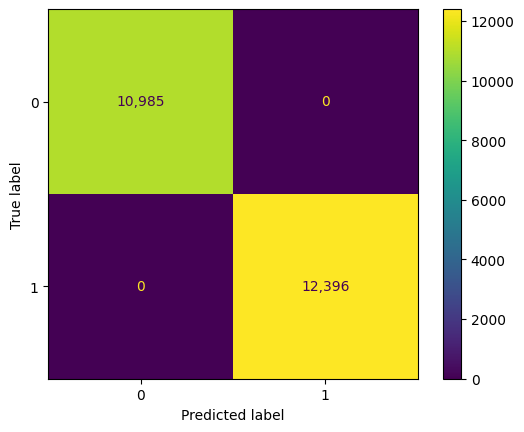

Holdout Data
-----------


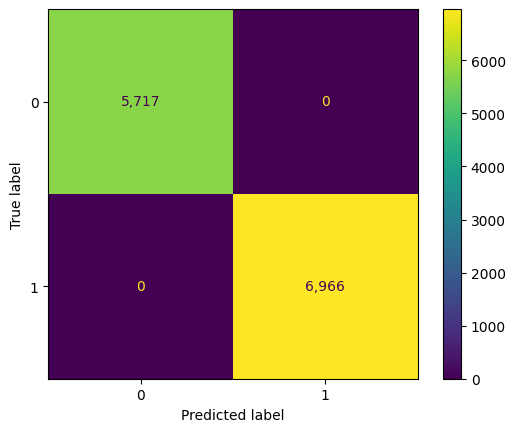

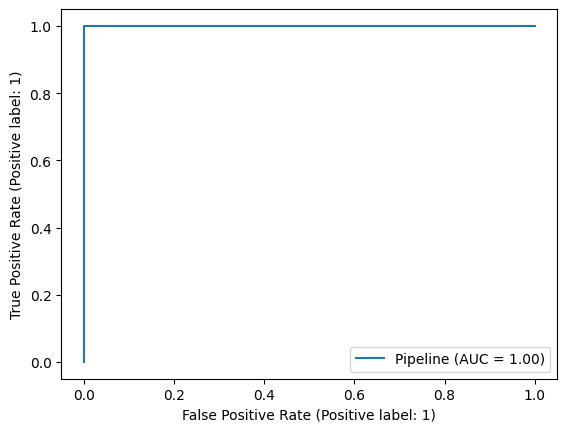

DecisionTreeClassifier() doesn't return probabilities, so no streak results will be returned based on this alone.
Odds multiplied by PA/G_batter
-----------
Val data
-----------
Longest streak in set (84 days):  84
Total correct guesses in set (84 days):  84 1.0
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
Odds added to PA/G_batter
-----------
Val data
-----------
Longest streak in set (84 days):  3
Total correct guesses in set (84 days):  28 0.3333333333333333
Holdout data
-----------
Longest streak in set (45 days):  6
Total correct guesses in set (45 days):  24 0.5333333333333333


In [29]:
start = datetime.now()
dt = DecisionTreeClassifier()

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', dt)
])

run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 2: Logistic Regression

In [48]:
start = datetime.now()

logreg = LogisticRegression(solver='sag')

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', logreg)
])

run_model(clf, X_train, X_val, y_train, y_val, holdout, names=names)

NameError: name 'names' is not defined

# Model 3: SVC too slow, linearSVC doesn't supply probability, so I need to supply a secondary way to select a single batter per day

In [ ]:
start = datetime.now()

Linearsvc = LinearSVC()


clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linearsvc', Linearsvc)
])


run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 4: KNN - 5 neighbors

In [ ]:
start = datetime.now()

knn = KNeighborsClassifier(n_jobs=-1)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])


run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 4: KNN - 3 neighbors

In [ ]:
start = datetime.now()

knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])


run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 5: Random Forest

Model should take between 0 and 4 minutes to run and finish by 13:26
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Val Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 0.9999999999999999
Precision: 1.0
-----------------------------------
Holdout Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0

Val Data
-----------


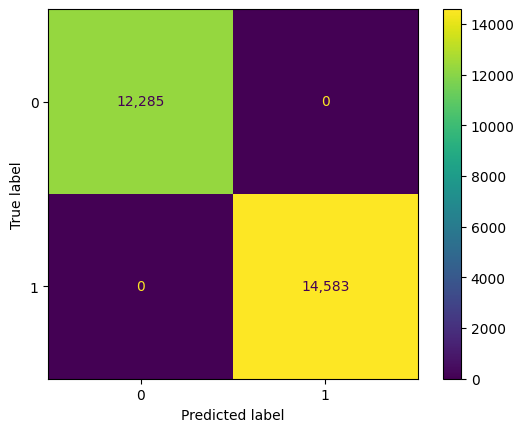

Holdout Data
-----------


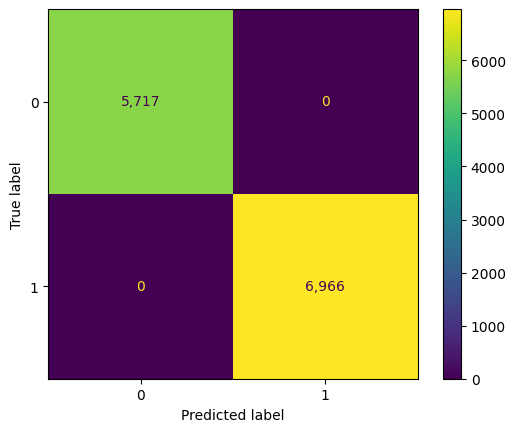

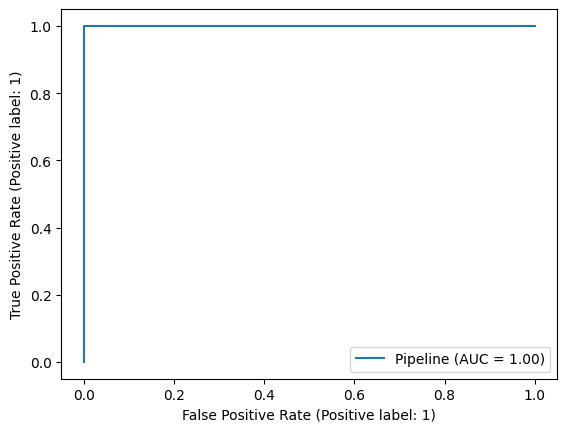

-----------------------------------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds multiplied by PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds added to PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  6
Total correct guesses in set (95 days):  44 0.4631578947368421
-----------
Holdout data
-----------
Longest streak in set (45 days):  6
Total correct guesses in set (45 days):  24 0.5333333333333333


In [388]:
start = datetime.now()

rfc = RandomForestClassifier(n_jobs=-1)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc', rfc)
])

run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 6: AdaBoost


Model should take between 0 and 2 minutes to run and finish by 13:24
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Val Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Holdout Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0

Val Data
-----------


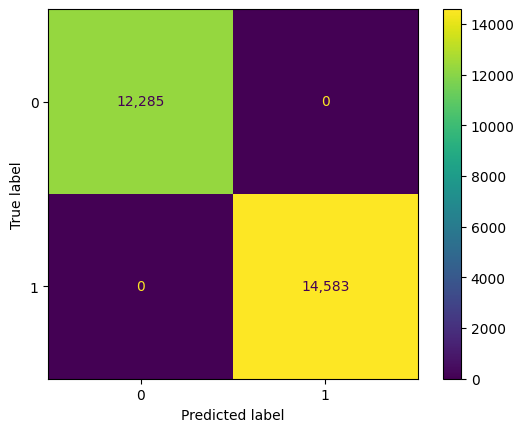

Holdout Data
-----------


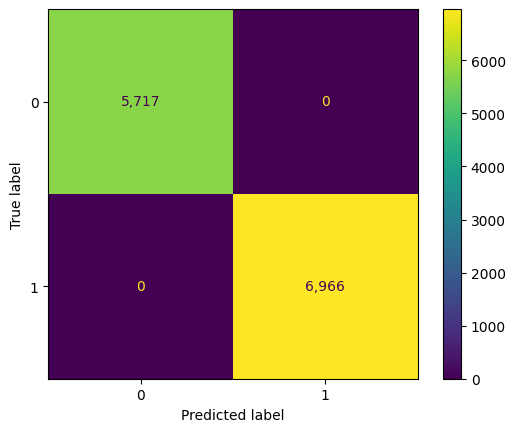

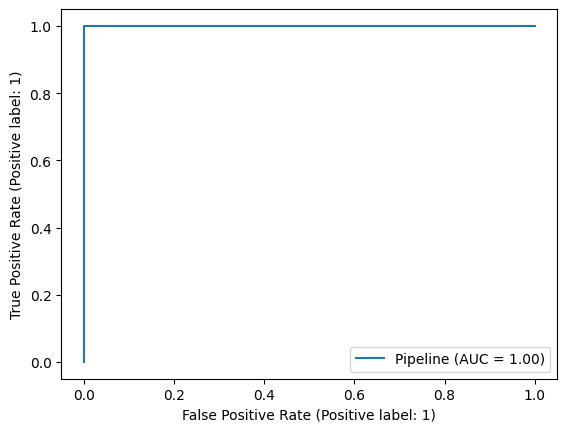

-----------------------------------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds multiplied by PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds added to PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  6
Total correct guesses in set (95 days):  44 0.4631578947368421
-----------
Holdout data
-----------
Longest streak in set (45 days):  6
Total correct guesses in set (45 days):  24 0.5333333333333333


In [389]:
start = datetime.now()

ada = AdaBoostClassifier(random_state=42)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ada', ada)
])

run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 7: GradientBoost


Model should take between 0 and 2 minutes to run and finish by 13:24
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Val Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Holdout Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0

Val Data
-----------


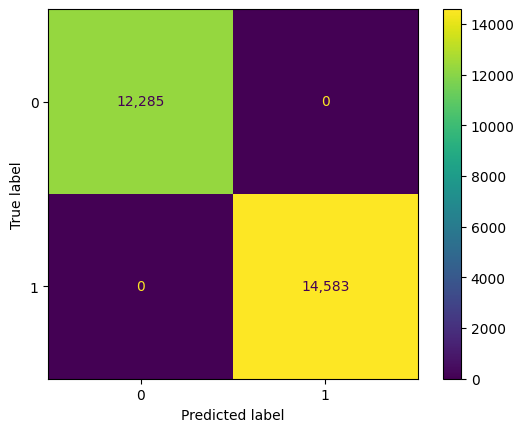

Holdout Data
-----------


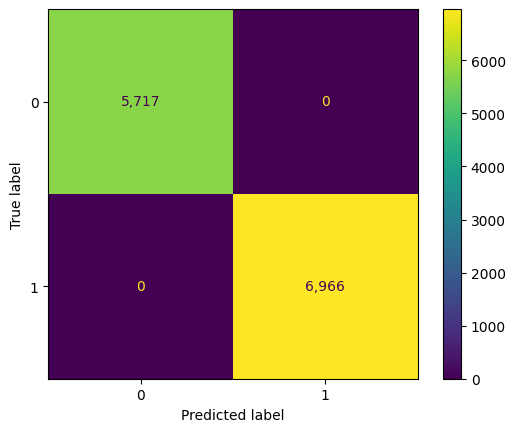

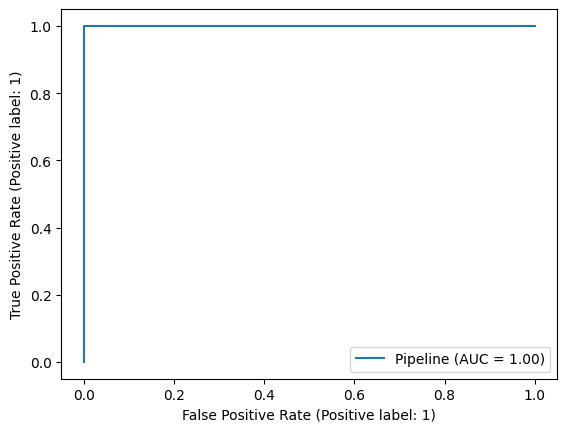

-----------------------------------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds multiplied by PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds added to PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  6
Total correct guesses in set (95 days):  44 0.4631578947368421
-----------
Holdout data
-----------
Longest streak in set (45 days):  6
Total correct guesses in set (45 days):  24 0.5333333333333333


In [390]:
start = datetime.now()

gbm = GradientBoostingClassifier()
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gbm', gbm)
])

run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 8: XGBoost


[13:23:54] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model should take between 0 and 3 minutes to run and finish by 13:26
[13:23:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Val Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0
-----------------------------------
Holdout Scores
-----------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Precision: 1.0

Val Data
-

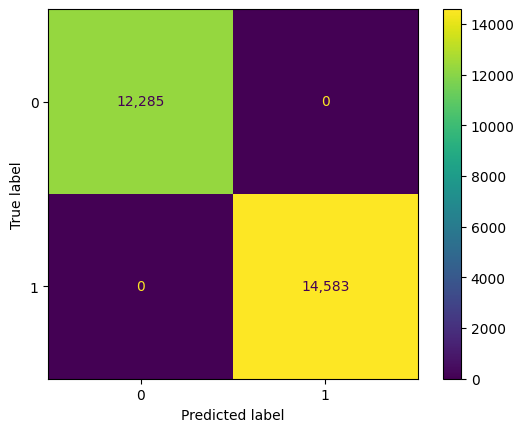

Holdout Data
-----------


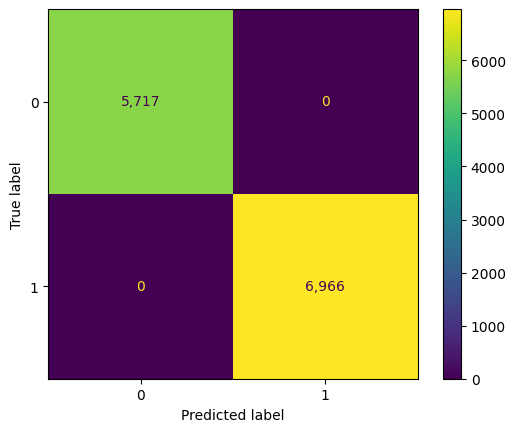

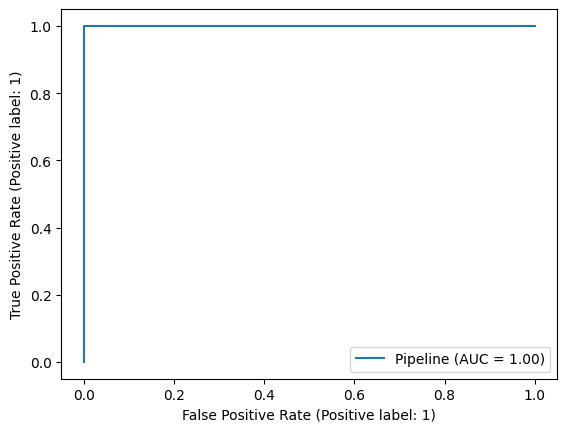

-----------------------------------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds multiplied by PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  95
Total correct guesses in set (95 days):  95 1.0
-----------
Holdout data
-----------
Longest streak in set (45 days):  45
Total correct guesses in set (45 days):  45 1.0
-----------------------------------
Odds added to PA/G_batter
-----------
Val data
-----------
Longest streak in set (95 days):  6
Total correct guesses in set (95 days):  44 0.4631578947368421
-----------
Holdout data
-----------
Longest streak in set (45 days):  6
Total correct guesses in set (45 days):  24 0.5333333333333333


In [391]:
start = datetime.now()

xbg = xgb.XGBClassifier(random_state=42)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xbg', xbg)
])

run_model(clf, X_train, X_val, y_train, y_val, holdout)

# Model 9: Random Forest with Grid Search


In [ ]:
start = datetime.now()

parameters = {
    'min_samples_split': [3, 5, 100], 
    'n_estimators' : [100, 300],
        'max_depth': [3, 5, 15, 25],

}

estimator = RandomForestClassifier(random_state=42)

grid = GridSearchCV(estimator, parameters, n_jobs=-1, cv=5, scoring = 'precision')

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('grid', grid)
])

clf.fit(X_train, y_train)
print(datetime.now()-start)

estimator = RandomForestClassifier(n_jobs=-1).set_params(grid.best_params_)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('grid', estimator)
])

# clf.fit(X_train, y_train)
run_model(clf, X_train, X_val, y_train, y_val, holdout)